In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import QuantileTransformer, MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage


In [3]:
df1 = pd.read_csv('/content/drive/MyDrive/game_preference.csv')

In [4]:
columns_to_drop = ['developer', 'publisher', 'score_rank', 'positive', 'negative', 'owners', 'currency', 'positive_ratio']
df1= df1.drop(columns=columns_to_drop)

# Display the remaining columns to verify
df1.head()


,appid,name,average_forever,average_2weeks,median_forever,median_2weeks,ccu,genre,final,categories 1,categories 2,ratings,owners_average,MutualPlayerCount
0,10,Counter-Strike,8894,525,157,757,12121,Action,9.99,Multi-player,PvP,0.952840,15000000,831
1,30,Day of Defeat,158,188,15,188,110,Action,4.99,Multi-player,Valve Anti-Cheat enabled,0.801467,7500000,103
2,70,Half-Life,574,50,134,75,1135,Action,9.99,Single-player,Multi-player,0.930085,15000000,525
3,220,Half-Life 2,838,35,350,59,1172,Action,9.99,Single-player,Steam Achievements,0.949639,7500000,1068
4,240,Counter-Strike: Source,9450,489,394,848,9549,Action,9.99,Multi-player,Cross-Platform Multiplayer,0.935661,15000000,1039


In [5]:
df1.rename(columns = {'final' : 'price'}, inplace = True)

In [6]:
# Ensure 'genre' is either list or string
print("Before converting lists to strings in 'genre':")
print(df1['genre'].head())

if any(df1['genre'].apply(lambda x: isinstance(x, list))):
    df1['genre'] = df1['genre'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

print("After converting lists to strings in 'genre':")
print(df1['genre'].head())

# Clean the 'categories 2' column by stripping leading/trailing spaces
df1['categories 2'] = df1['categories 2'].str.strip()

print("After stripping spaces in 'categories 2':")
print(df1['categories 2'].head())

# Filter 'categories 2' to include only 'Single-player' and 'Multi-player'
df1['categories 2'] = df1['categories 2'].apply(lambda x: x if x in ['Single-player', 'Multi-player'] else None)

print("After filtering 'categories 2':")
print(df1['categories 2'].head())

# OneHotEncoder initialization with handle_unknown set to 'ignore'
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Encoding 'categories 1'
categories_1_valid = df1[['categories 1']].dropna()
categories_encoded_1 = one_hot_encoder.fit_transform(categories_1_valid)
cat1_feature_names = ['cat_1_' + feature.split('_')[-1] for feature in one_hot_encoder.get_feature_names_out()]
categories_encoded_df1_1 = pd.DataFrame(categories_encoded_1, columns=cat1_feature_names, index=categories_1_valid.index)

print("Encoded 'categories 1':")
print(categories_encoded_df1_1.head())

# Encoding 'categories 2'
categories_2_valid = df1[['categories 2']].fillna('Ignore')
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', categories=[['Single-player', 'Multi-player']])
categories_encoded_2 = one_hot_encoder.fit_transform(categories_2_valid)
cat2_feature_names = ['cat_2_' + feature.split('_')[-1] for feature in one_hot_encoder.categories_[0]]
categories_encoded_df1_2 = pd.DataFrame(categories_encoded_2, columns=cat2_feature_names, index=categories_2_valid.index)

print("Encoded 'categories 2':")
print(categories_encoded_df1_2.head())

# Joining the new DataFrames with the original data
data_encoded = df1.join(categories_encoded_df1_1).join(categories_encoded_df1_2)

print("Data after joining encoded categories:")
print(data_encoded[['cat_1_Single-player', 'cat_1_Multi-player', 'cat_2_Single-player', 'cat_2_Multi-player']].head())

# Function to split the genres into lists of individual genres
def split_genres(genre):
    if pd.isna(genre):
        return []
    return [g.strip() for g in genre.split(',')]

# Apply the function to the genre column
data_encoded['genre'] = data_encoded['genre'].apply(split_genres)

print("After splitting 'genre' into lists:")
print(data_encoded['genre'].head())

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the genre data
genres_encoded = mlb.fit_transform(data_encoded['genre'])

# Create a DataFrame from the encoded genres
genres_encoded_df1 = pd.DataFrame(genres_encoded, columns=mlb.classes_)

print("Encoded 'genre':")
print(genres_encoded_df1.head())

# Merge the encoded DataFrame with the original data
data_encoded = data_encoded.join(genres_encoded_df1)

# Display the first few rows to check the result
print("Final encoded DataFrame:")
print(data_encoded.head())

Before converting lists to strings in 'genre':
0    Action
1    Action
2    Action
3    Action
4    Action
Name: genre, dtype: object
After converting lists to strings in 'genre':
0    Action
1    Action
2    Action
3    Action
4    Action
Name: genre, dtype: object
After stripping spaces in 'categories 2':
0                           PvP
1      Valve Anti-Cheat enabled
2                  Multi-player
3            Steam Achievements
4    Cross-Platform Multiplayer
Name: categories 2, dtype: object
After filtering 'categories 2':
0            None
1            None
2    Multi-player
3            None
4            None
Name: categories 2, dtype: object
Encoded 'categories 1':
   cat_1_Multi-player  cat_1_Single-player
0                 1.0                  0.0
1                 1.0                  0.0
2                 0.0                  1.0
3                 0.0                  1.0
4                 1.0                  0.0
Encoded 'categories 2':
   cat_2_Single-player  cat_2_Multi

In [7]:
# now removing unnecessary columns
columns_to_drop = ['categories 2','categories 1', 'genre']
data_encoded= data_encoded.drop(columns=columns_to_drop)

# Display the remaining columns to verify
data_encoded.head()


,appid,name,average_forever,average_2weeks,median_forever,median_2weeks,ccu,price,ratings,owners_average,...,Nudity,RPG,Racing,Sexual Content,Simulation,Sports,Strategy,Utilities,Violent,Web Publishing
0,10,Counter-Strike,8894,525,157,757,12121,9.99,0.952840,15000000,...,0,0,0,0,0,0,0,0,0,0
1,30,Day of Defeat,158,188,15,188,110,4.99,0.801467,7500000,...,0,0,0,0,0,0,0,0,0,0
2,70,Half-Life,574,50,134,75,1135,9.99,0.930085,15000000,...,0,0,0,0,0,0,0,0,0,0
3,220,Half-Life 2,838,35,350,59,1172,9.99,0.949639,7500000,...,0,0,0,0,0,0,0,0,0,0
4,240,Counter-Strike: Source,9450,489,394,848,9549,9.99,0.935661,15000000,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Print null values count before dropping
print("Before dropping nulls:")
print(data_encoded.isnull().sum())



Before dropping nulls:
appid                    0
name                     2
average_forever          0
average_2weeks           0
median_forever           0
median_2weeks            0
ccu                      0
price                    0
ratings                  0
owners_average           0
MutualPlayerCount        0
cat_1_Multi-player       0
cat_1_Single-player      0
cat_2_Single-player      0
cat_2_Multi-player       0
Action                   0
Adventure                0
Animation & Modeling     0
Casual                   0
Design & Illustration    0
Early Access             0
Education                0
Free to Play             0
Game Development         0
Gore                     0
Indie                    0
Massively Multiplayer    0
Movie                    0
Nudity                   0
RPG                      0
Racing                   0
Sexual Content           0
Simulation               0
Sports                   0
Strategy                 0
Utilities                0
Viole

In [9]:

# Drop rows with any null values directly in the original DataFrame
df1.dropna(inplace=True)

# Print null values count after dropping to verify
print("After dropping nulls:")
print(df1.isnull().sum())

After dropping nulls:
appid                0
name                 0
average_forever      0
average_2weeks       0
median_forever       0
median_2weeks        0
ccu                  0
genre                0
price                0
categories 1         0
categories 2         0
ratings              0
owners_average       0
MutualPlayerCount    0
dtype: int64


In [10]:
# Summing the columns for 'Single-player'
data_encoded['single player'] = data_encoded['cat_1_Single-player'] + data_encoded['cat_2_Single-player']
data_encoded['single player'] = data_encoded['single player'].clip(upper=1)  # Ensure the maximum value is 1

# Summing the columns for 'Multi-player'
data_encoded['multi player'] = data_encoded['cat_1_Multi-player'] + data_encoded['cat_2_Multi-player']
data_encoded['multi player'] = data_encoded['multi player'].clip(upper=1)  # Ensure the maximum value is 1

# Display the first few rows to check the new columns
print(data_encoded[['single player', 'multi player']].head())


   single player  multi player
0            0.0           1.0
1            0.0           1.0
2            1.0           1.0
3            1.0           0.0
4            0.0           1.0


In [11]:
# Create the 'both' column based on the condition
data_encoded['both'] = ((data_encoded['single player'] == 1) & (data_encoded['multi player'] == 1)).astype(int)

# Set 'single player' and 'multi player' to 0 where 'both' is 1
data_encoded.loc[data_encoded['both'] == 1, ['single player', 'multi player']] = 0

# Display the updated DataFrame
print(data_encoded)

      appid                                         name  average_forever  \
0        10                               Counter-Strike             8894   
1        30                                Day of Defeat              158   
2        70                                    Half-Life              574   
3       220                                  Half-Life 2              838   
4       240                       Counter-Strike: Source             9450   
..      ...                                          ...              ...   
831  812450                             The m0rg VS keys                0   
832  815830                                Space Escape!                0   
833  816710                                     Gray Cat               16   
834  817110                             Bitcoin VS Brain                0   
835  821720  20.000 Leagues Under The Sea - Captain Nemo                0   

     average_2weeks  median_forever  median_2weeks    ccu  price   ratings 

In [12]:
# now removing unnecessary columns
columns_to_drop = ['cat_1_Multi-player','cat_1_Single-player', 'cat_2_Single-player', 'cat_2_Multi-player']
data_encoded= data_encoded.drop(columns=columns_to_drop)

# Display the remaining columns to verify
data_encoded.columns


Index(['appid', 'name', 'average_forever', 'average_2weeks', 'median_forever',
       'median_2weeks', 'ccu', 'price', 'ratings', 'owners_average',
       'MutualPlayerCount', 'Action', 'Adventure', 'Animation & Modeling',
       'Casual', 'Design & Illustration', 'Early Access', 'Education',
       'Free to Play', 'Game Development', 'Gore', 'Indie',
       'Massively Multiplayer', 'Movie', 'Nudity', 'RPG', 'Racing',
       'Sexual Content', 'Simulation', 'Sports', 'Strategy', 'Utilities',
       'Violent', 'Web Publishing', 'single player', 'multi player', 'both'],
      dtype='object')

### Raw data distribution

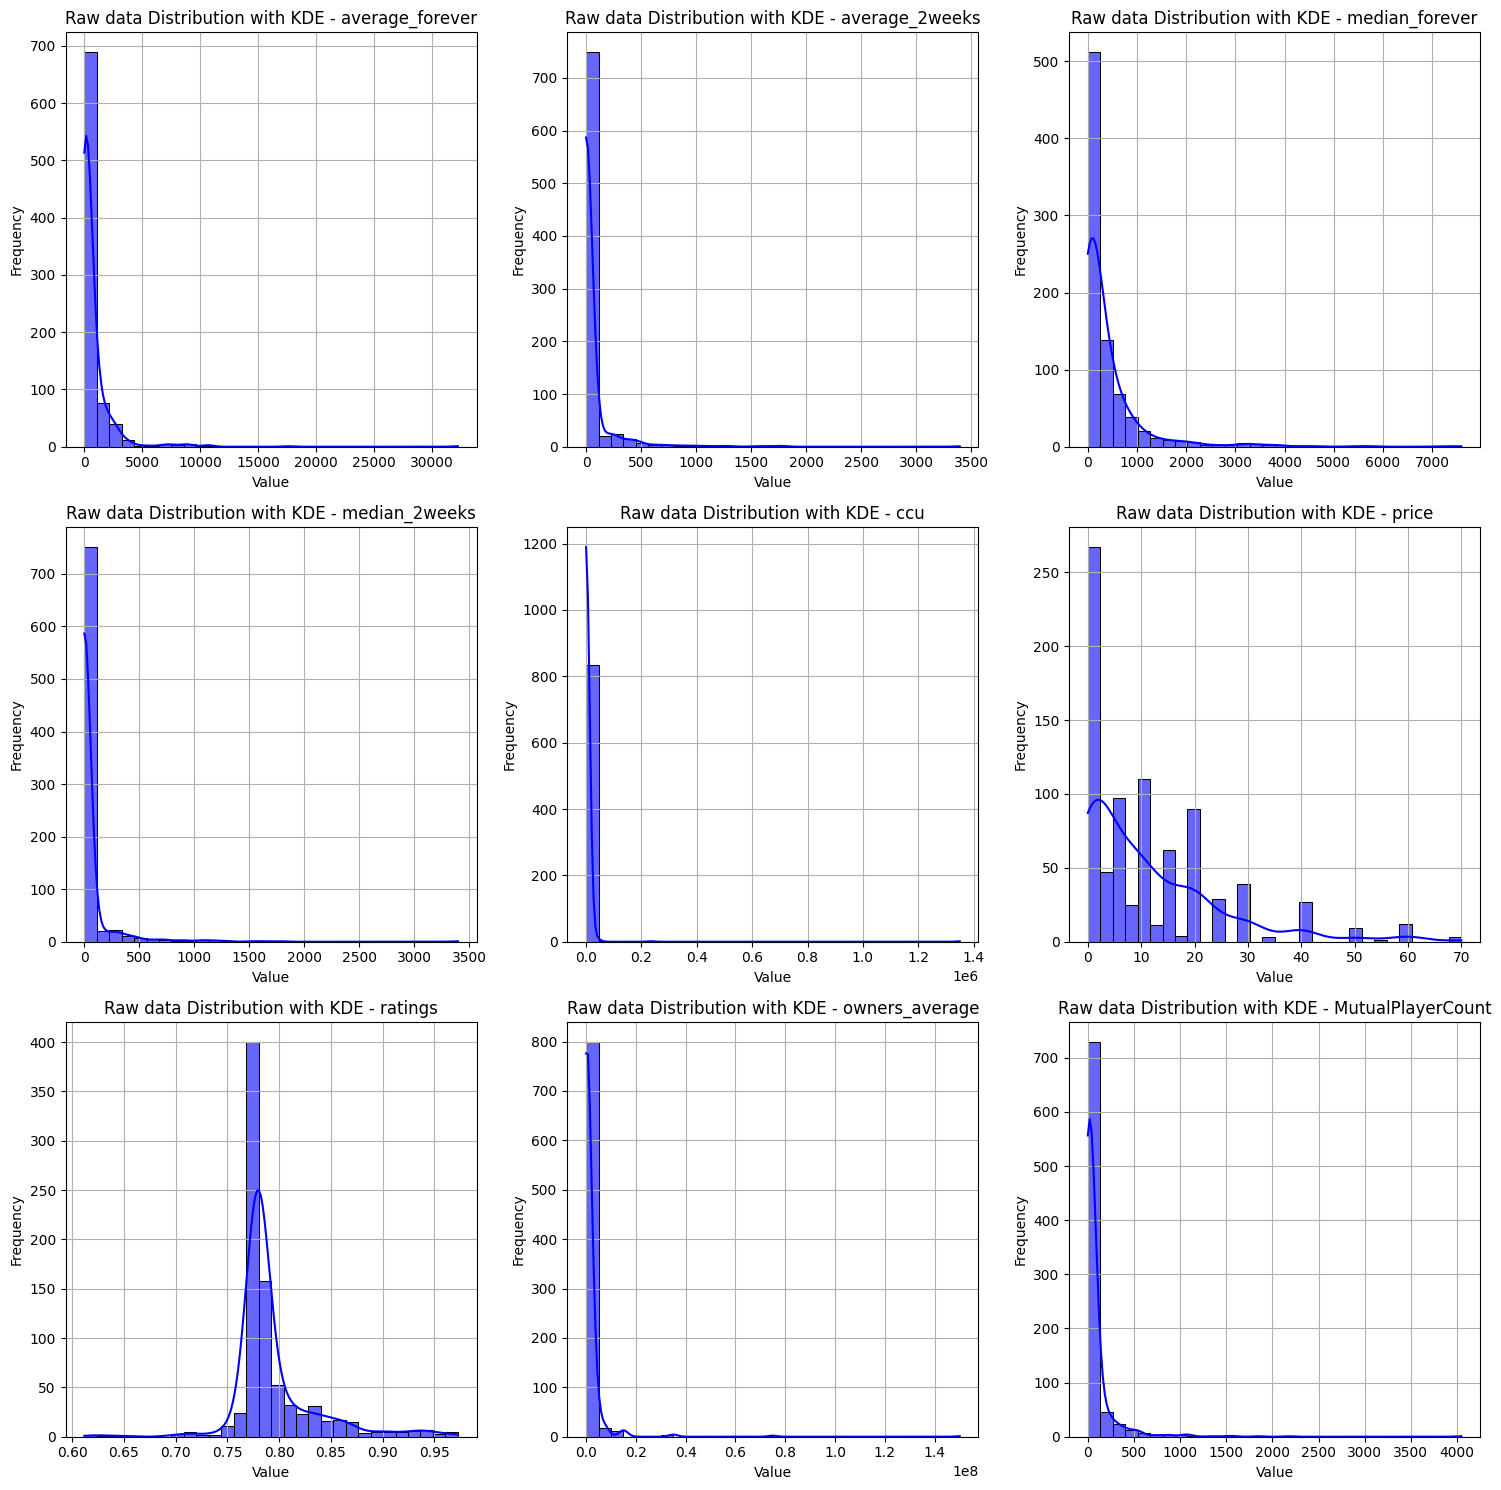

In [13]:
# Specify the columns you want to plot
columns_to_transform = ['average_forever', 'average_2weeks', 'median_forever',
                        'median_2weeks', 'ccu', 'price', 'ratings', 'owners_average',
                        'MutualPlayerCount']

# Determine the layout of the subplots
num_columns = 3  # Define the number of columns in your subplot grid
num_rows = (len(columns_to_transform) + num_columns - 1) // num_columns  # Calculate the number of rows needed

# Create a figure and a set of subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through the list of columns and create a plot for each one
for i, col in enumerate(columns_to_transform):
    sns.histplot(data_encoded[col], bins=30, kde=True, color='blue', alpha=0.6, ax=axes[i])
    axes[i].set_title(f'Raw data Distribution with KDE - {col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# If there are any leftover axes, turn them off
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Show the plot
plt.show()


### log transformation

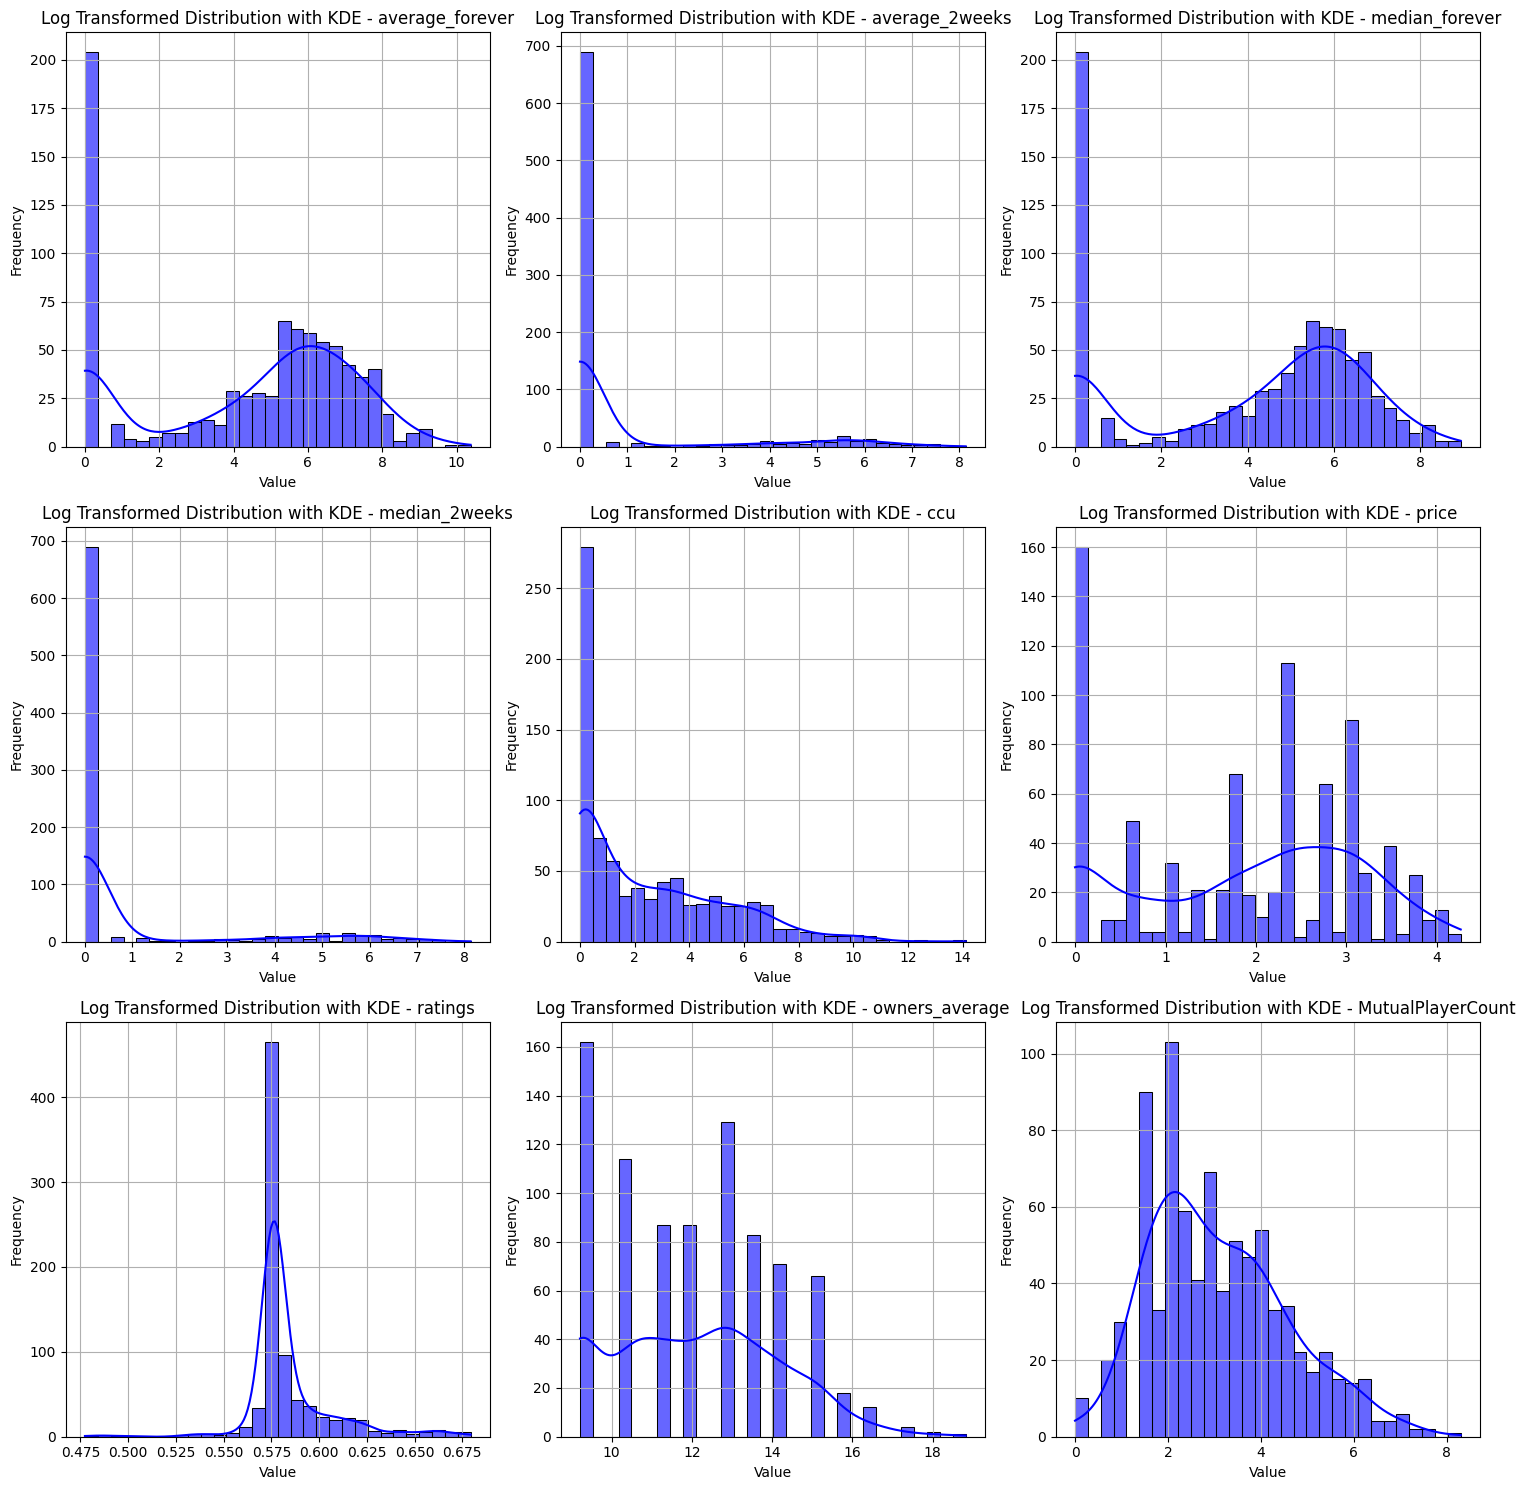

In [14]:
def apply_log_transformation(data, columns):
    transformed_data = data.copy()  # Create a copy of the data to keep the original dataframe untouched
    constant = 1  # You can adjust the constant as necessary
    for col in columns:
        transformed_data[col] = np.log(transformed_data[col] + constant)
    return transformed_data

# List of columns to transform
columns_to_transform = ['average_forever', 'average_2weeks', 'median_forever',
       'median_2weeks', 'ccu', 'price', 'ratings', 'owners_average',
       'MutualPlayerCount']  # Add your specific column names here

# Apply the log transformation function to a copy for plotting
df1_transformed = apply_log_transformation(data_encoded, columns_to_transform)

# Determine the layout of the subplots
num_columns = 3  # Define the number of columns in your subplot grid
num_rows = (len(columns_to_transform) + num_columns - 1) // num_columns  # Calculate the number of rows needed

# Create a figure and a set of subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through the list of columns and create a plot for each one
for i, col in enumerate(columns_to_transform):
    sns.histplot(df1_transformed[col], bins=30, kde=True, color='blue', alpha=0.6, ax=axes[i])
    axes[i].set_title(f'Log Transformed Distribution with KDE - {col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# If there are any leftover axes, turn them off
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Show the plot
plt.show()


### box cox transformation

Number of zero values after transforming average_forever: 204
Number of zero values after transforming average_2weeks: 689
Number of zero values after transforming median_forever: 204
Number of zero values after transforming median_2weeks: 689
Number of zero values after transforming ccu: 279
Number of zero values after transforming price: 160
Number of zero values after transforming ratings: 1
Number of zero values after transforming owners_average: 162
Number of zero values after transforming MutualPlayerCount: 10


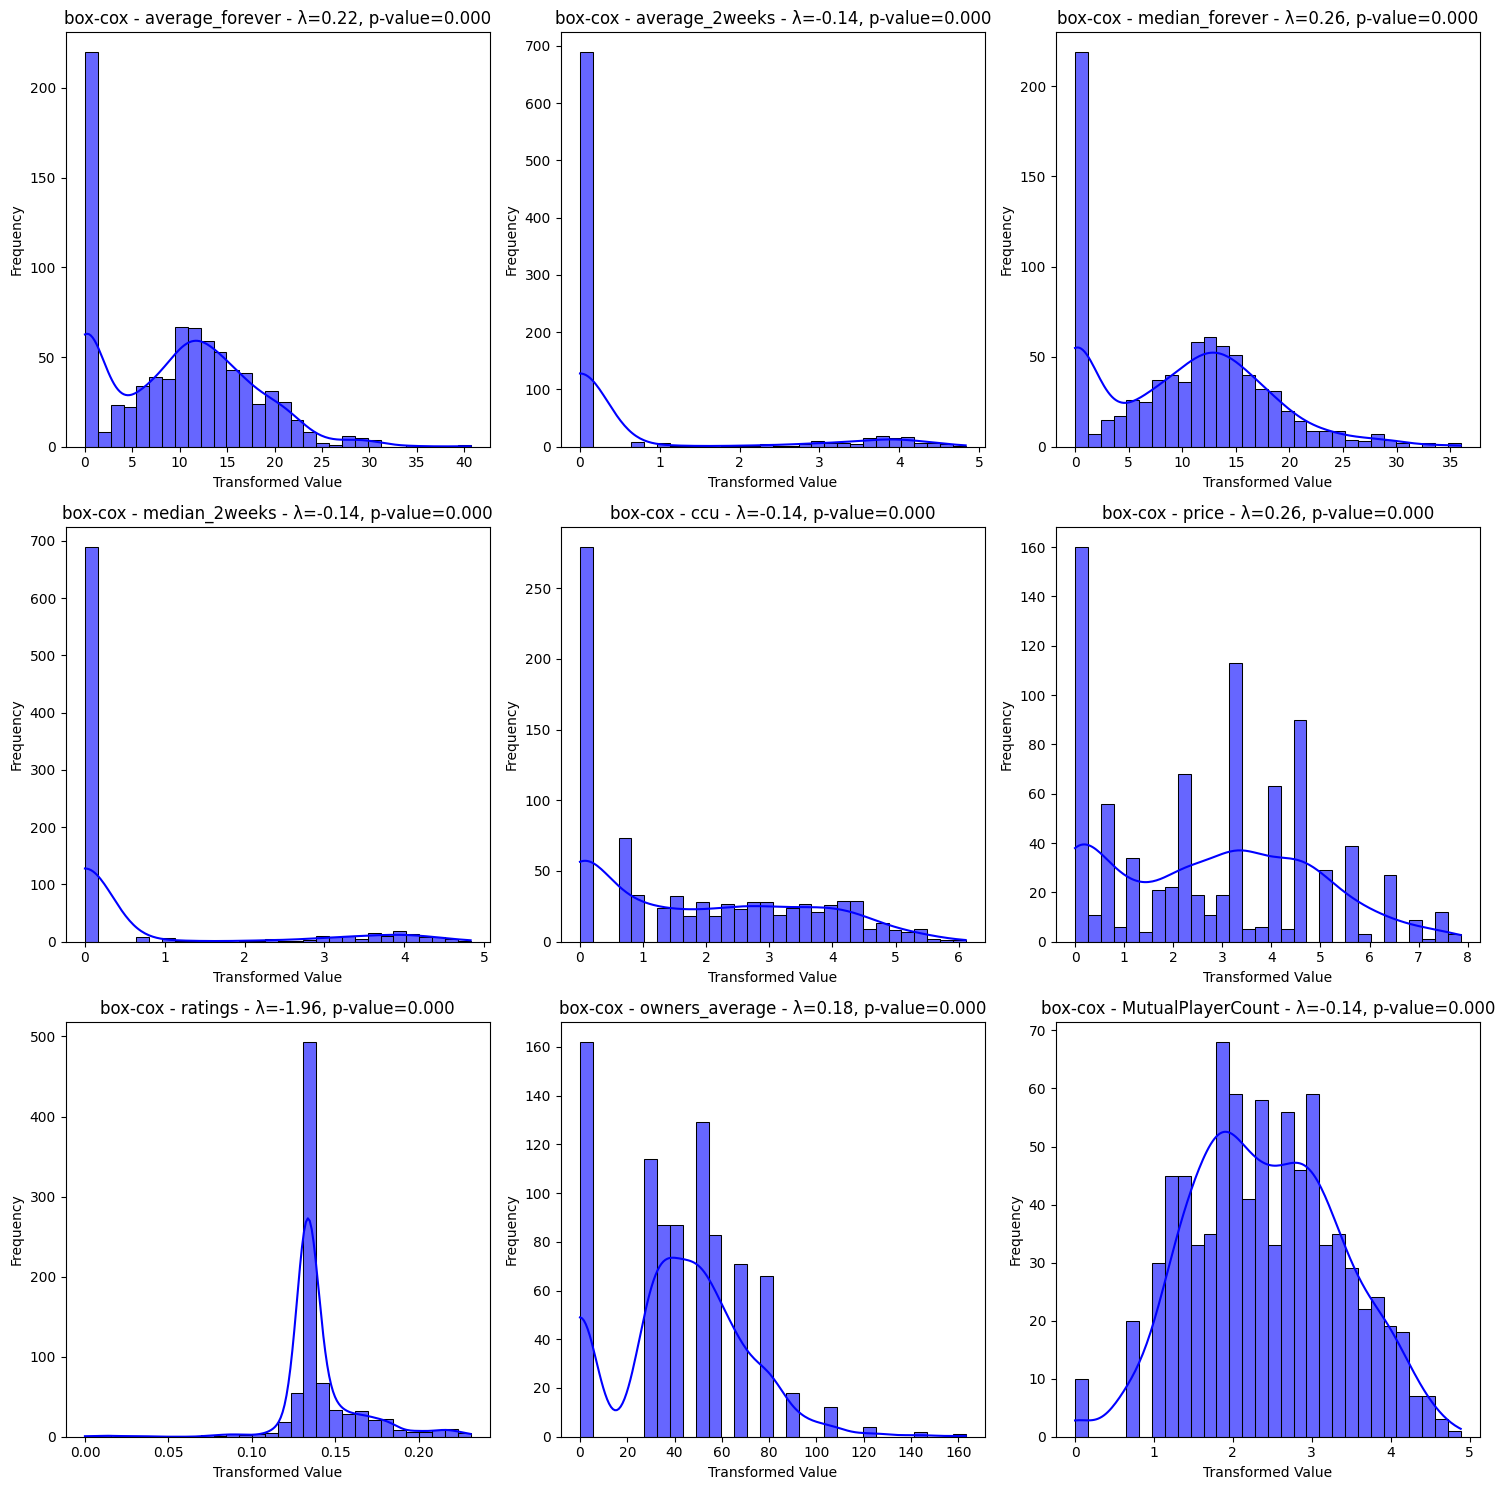

In [15]:
# Your specified columns to transform
columns_to_transform = ['average_forever', 'average_2weeks', 'median_forever',
                        'median_2weeks', 'ccu', 'price', 'ratings', 'owners_average',
                        'MutualPlayerCount']

# Prepare a subplot layout
num_columns = 3
num_rows = (len(columns_to_transform) + num_columns - 1) // num_columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
axes = axes.flatten()

# Explore a range of lambda values for each column
for index, col in enumerate(columns_to_transform):
    lambdas = np.linspace(-2, 2, num=100)  # Range of lambda values to explore
    best_pvalue = 0
    best_lambda = None
    best_transformed_data = None

    # Ensure all data are positive
    data_shifted = data_encoded[col] + 1 - np.min(data_encoded[col])

    # Try different lambda values
    for l in lambdas:
        transformed_data = stats.boxcox(data_shifted, lmbda=l)  # Note the change here, only one output
        shapiro_test = stats.shapiro(transformed_data)
        if shapiro_test.pvalue > best_pvalue:
            best_pvalue = shapiro_test.pvalue
            best_lambda = l
            best_transformed_data = transformed_data

    zeros_count = (transformed_data == 0).sum()
    print(f"Number of zero values after transforming {col}: {zeros_count}")


    # Plot the best transformed data
    sns.histplot(best_transformed_data, bins=30, kde=True, color='blue', alpha=0.6, ax=axes[index])
    axes[index].set_title(f'box-cox - {col} - λ={best_lambda:.2f}, p-value={best_pvalue:.3f}')
    axes[index].set_xlabel('Transformed Value')
    axes[index].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# If there are any leftover axes, turn them off
for i in range(index + 1, len(axes)):
    axes[i].axis('off')

# Show the plot
plt.show()

### Spliting data before applying transformation

In [16]:
df_model = data_encoded.copy()

# Split the data into train, validation, and test sets
train_data, temp_data = train_test_split(df_model, test_size=0.2, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Print the sizes of each split
print(f"Train Data Size: {train_data.shape[0]} samples")
print(f"Validation Data Size: {validation_data.shape[0]} samples")
print(f"Test Data Size: {test_data.shape[0]} samples")


Train Data Size: 668 samples
Validation Data Size: 84 samples
Test Data Size: 84 samples


## quantile transformation

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (668). n_quantiles is set to n_samples.
  warnings.warn(


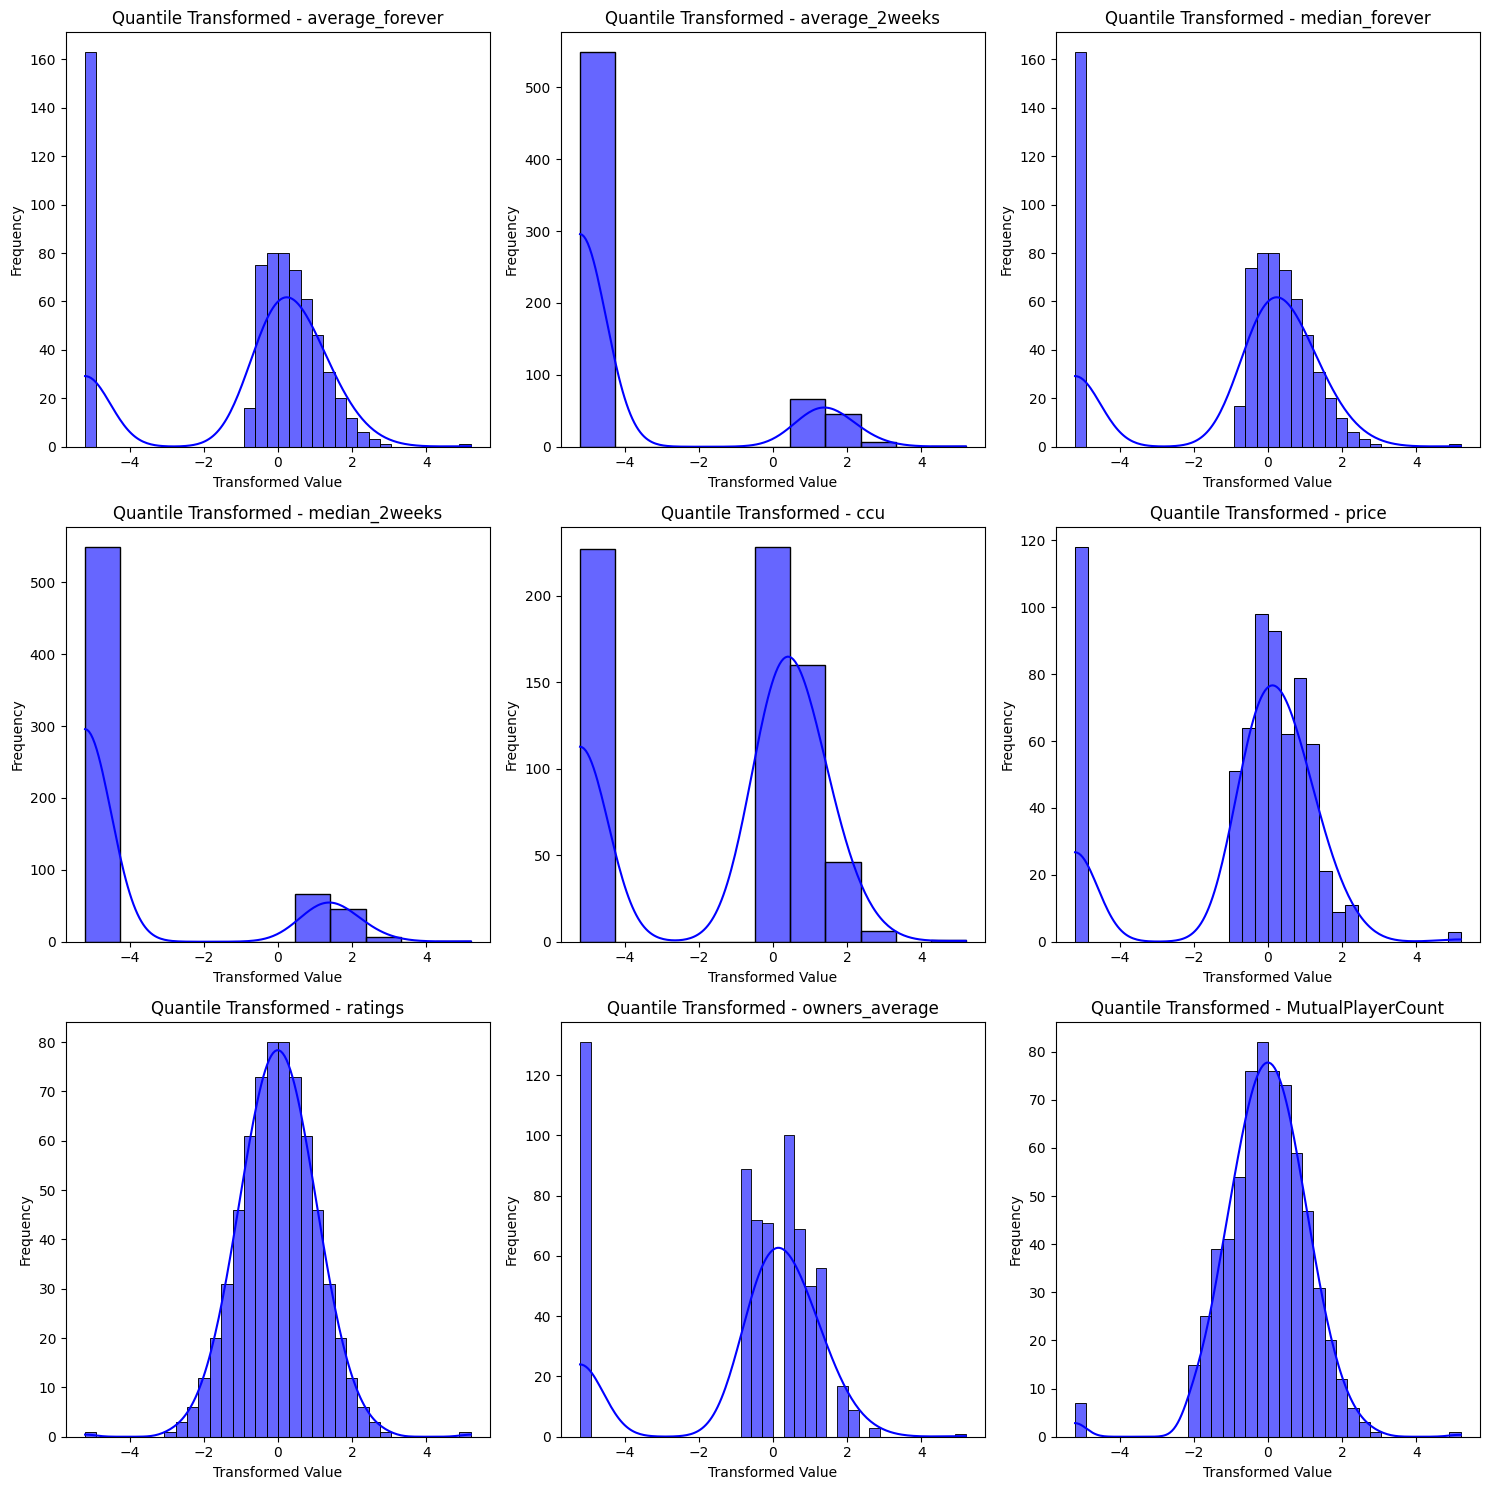

In [17]:
# Apply quantile transformation
def apply_quantile_transformation(train, validation, test):
    quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42)
    feature_cols = ['average_forever', 'average_2weeks', 'median_forever',
                    'median_2weeks', 'ccu', 'price', 'ratings', 'owners_average',
                    'MutualPlayerCount']  # Replace with actual feature column names

    train_transformed = train.copy()
    validation_transformed = validation.copy()
    test_transformed = test.copy()

    # Fit the transformer on the training data
    quantile_transformer.fit(train[feature_cols])

    # Apply the transformation to the training data
    train_transformed_cols = quantile_transformer.transform(train[feature_cols])
    validation_transformed_cols = quantile_transformer.transform(validation[feature_cols])
    test_transformed_cols = quantile_transformer.transform(test[feature_cols])

    # Add suffix to new columns and assign transformed data
    for i, col in enumerate(feature_cols):
        train_transformed[col + '_qt_normal'] = train_transformed_cols[:, i]
        validation_transformed[col + '_qt_normal'] = validation_transformed_cols[:, i]
        test_transformed[col + '_qt_normal'] = test_transformed_cols[:, i]

    return train_transformed, validation_transformed, test_transformed

# Apply quantile transformation
train_transformed, validation_transformed, test_transformed = apply_quantile_transformation(train_data, validation_data, test_data)


# Check for transformed columns
for col in ['average_forever', 'average_2weeks', 'median_forever',
                    'median_2weeks', 'ccu', 'price', 'ratings', 'owners_average',
                    'MutualPlayerCount']:
    transformed_col = col + '_qt_normal'
    if transformed_col not in train_transformed.columns:
        print(f"Column {transformed_col} is missing from the transformed DataFrame")

# Plot density histograms for the transformed data
def plot_transformed_density_histograms(data, feature_cols):
    # Prepare a subplot layout
    num_columns = 3
    num_rows = (len(feature_cols) + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
    axes = axes.flatten()

    # Loop through the list of columns and plot the transformed data
    for i, col in enumerate(feature_cols):
        transformed_col = col + '_qt_normal'

        # Check if the column exists in the DataFrame
        if transformed_col not in data.columns:
            print(f"Column {transformed_col} does not exist in the DataFrame")
            continue

        # Plot the transformed data
        sns.histplot(data[transformed_col], kde=True, color='blue', alpha=0.6, ax=axes[i])
        axes[i].set_title(f'Quantile Transformed - {col}')
        axes[i].set_xlabel('Transformed Value')
        axes[i].set_ylabel('Frequency')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # If there are any leftover axes, turn them off
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Show the plot
    plt.show()

# Plot density histograms for the transformed training data
feature_cols = ['average_forever', 'average_2weeks', 'median_forever',
                    'median_2weeks', 'ccu', 'price', 'ratings', 'owners_average',
                    'MutualPlayerCount']
plot_transformed_density_histograms(train_transformed, feature_cols)

### Agglomerative Hierarchical Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Best number of clusters based on silhouette score: 3
Silhouette score for best cluster size (3): 0.439
Silhouette score for validation data: 0.392
Silhouette score for test data: 0.431


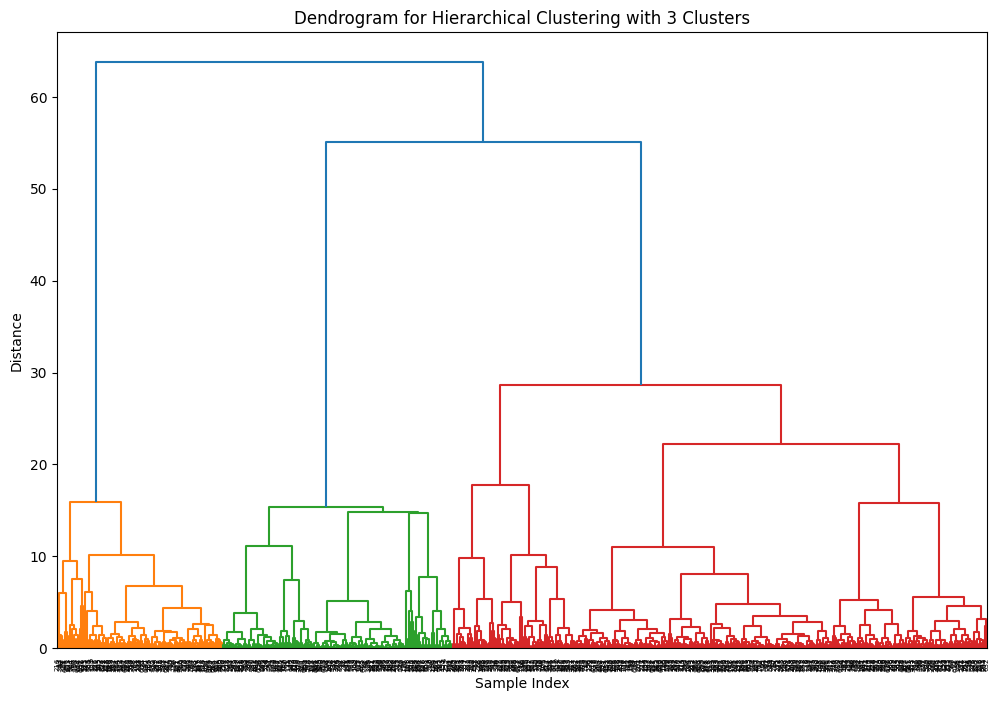

In [18]:
# Prepare data for clustering and perform hierarchical clustering
def prepare_data_for_clustering(train, validation, test):
    # Define feature columns with '_qt_normal' suffix
    feature_cols = train.filter(regex='qt_normal$').columns.tolist()

    # Fit the scaler on the training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train[feature_cols])

    # Transform the validation and test data
    X_validation_scaled = scaler.transform(validation[feature_cols])
    X_test_scaled = scaler.transform(test[feature_cols])

    # Generate the linkage matrix
    Z = linkage(X_train_scaled, method='ward', metric='euclidean')

    # Evaluate potential number of clusters and silhouette scores using training data
    max_clusters = 15  # Define a maximum number of clusters to test
    silhouette_scores = []
    for n_clusters in range(2, max_clusters):
        cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
        labels = cluster.fit_predict(X_train_scaled)
        score = silhouette_score(X_train_scaled, labels)
        silhouette_scores.append(score)

    # Select the number of clusters with the highest silhouette score
    best_cluster_size = np.argmax(silhouette_scores) + 2  # +2 because range starts at 2
    best_silhouette_score = max(silhouette_scores)

    # Apply clustering with the optimal number of clusters on training, validation, and test data
    best_cluster = AgglomerativeClustering(n_clusters=best_cluster_size, affinity='euclidean', linkage='ward')
    train['cluster'] = best_cluster.fit_predict(X_train_scaled)
    validation['cluster'] = best_cluster.fit_predict(X_validation_scaled)
    test['cluster'] = best_cluster.fit_predict(X_test_scaled)

    # Evaluate silhouette score on validation and test data
    validation_silhouette_score = silhouette_score(X_validation_scaled, validation['cluster'])
    test_silhouette_score = silhouette_score(X_test_scaled, test['cluster'])

    # Print the best results
    print(f"Best number of clusters based on silhouette score: {best_cluster_size}")
    print(f"Silhouette score for best cluster size ({best_cluster_size}): {best_silhouette_score:.3f}")
    print(f"Silhouette score for validation data: {validation_silhouette_score:.3f}")
    print(f"Silhouette score for test data: {test_silhouette_score:.3f}")

    # Plot dendrogram focusing on the best number of clusters
    plt.figure(figsize=(12, 8))
    dendrogram(Z, color_threshold=Z[-(best_cluster_size-1), 2])
    plt.title(f'Dendrogram for Hierarchical Clustering with {best_cluster_size} Clusters')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()

    return train, validation, test

# Prepare and cluster the data for train, validation, and test sets
train_clustered, validation_clustered, test_clustered = prepare_data_for_clustering(train_transformed, validation_transformed, test_transformed)


### combinig data for clustering

In [19]:
# Combine transformed data and cluster information back into df_model
df_model.loc[train_clustered.index, train_clustered.columns] = train_clustered
df_model.loc[validation_clustered.index, validation_clustered.columns] = validation_clustered
df_model.loc[test_clustered.index, test_clustered.columns] = test_clustered


### Similarity calculation


In [20]:
# Function to calculate similarity scores (for recommendations)
def calculate_similarity(df, features):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(df[features])
    return cosine_similarity(features_scaled)

# Calculate similarity scores for the entire dataset
similarity_scores = calculate_similarity(df_model, ['average_forever_qt_normal', 'ccu_qt_normal', 'ratings_qt_normal'])
df_model['similarity'] = similarity_scores.tolist()

print("Similarity scores calculated successfully for the entire dataset.")


Similarity scores calculated successfully for the entire dataset.


## Games recommended by AFKAdvantures

In [21]:
# Normalize column names in the DataFrame
df_model.columns = [col.lower().replace(' ', '_') for col in df_model.columns]
def recommend_games_interactive(df, similarity_scores, num_recommendations=5):
    available_categories = ['single player', 'multi player', 'both']
    available_genres = ['Action', 'Adventure', 'Animation & Modeling', 'Casual', 'Design & Illustration',
                        'Early Access', 'Education', 'Free to Play', 'Game Development', 'Gore', 'Indie',
                        'Massively Multiplayer', 'Movie', 'Nudity', 'RPG', 'Racing', 'Sexual Content',
                        'Simulation', 'Sports', 'Strategy', 'Utilities', 'Violent', 'Web Publishing']

    print("Available Categories:")
    for category in available_categories:
        print(f"- {category}")
    user_category = input("\nEnter the category you would like to play (e.g., 'single player'): ").lower().replace(' ', '_')

    print("\nAvailable Genres:")
    for genre in available_genres:
        print(f"- {genre}")
    user_genre = input("\nEnter the genre you like (e.g., 'Action'): ").lower().replace(' ', '_')

    if user_category not in df.columns or user_genre not in df.columns:
        print("Invalid category or genre provided. Please check your input.")
        return None

    # Filter the DataFrame based on user input
    filtered_df = df[(df[user_genre] == 1) & (df[user_category] == 1)]
    if filtered_df.empty:
        print("No games found matching your criteria.")
        return None

    cluster_mode = filtered_df['cluster'].mode()[0]  # Most common cluster in filtered games
    cluster_filtered_df = filtered_df[filtered_df['cluster'] == cluster_mode]

    # Calculate similarity scores for filtered games within the most common cluster
    game_indices = cluster_filtered_df.index
    user_game_similarities = similarity_scores[game_indices][:, game_indices]
    similarity_sum = np.sum(user_game_similarities, axis=0)
    if np.max(similarity_sum) == 0:
        print("Similarity scores are all zero.")
        return None
    similarity_sum_normalized = similarity_sum / np.max(similarity_sum)  # Normalize the scores

    # Fetch the most similar games based on normalized scores within the cluster
    most_similar_indices = np.argsort(-similarity_sum_normalized)[:num_recommendations]
    recommendations = cluster_filtered_df.iloc[most_similar_indices]

    # Preparing the final DataFrame to return
    recommendations = recommendations[['name', 'ratings', 'price', 'cluster']]
    recommendations['scaled_similarity_score'] = similarity_sum_normalized[most_similar_indices]
    recommendations[user_genre] = 1  # Since user_genre is dynamically chosen, mark it as 1 (selected)
    recommendations[user_category] = 1  # Since user_category is dynamically chosen, mark it as 1 (selected)

    return recommendations.style.bar(subset=['scaled_similarity_score', 'ratings'], color='#fd7e14')\
                        .format({
                            'ratings': "{:.2f}",
                            'price': "${:.2f}",
                            'scaled_similarity_score': "{:.4f}"
                        })\
                        .set_properties(**{'background-color': '#343a40', 'color': '#ffffff'})\
                        .set_caption("Top Recommended Games")\
                        .set_table_styles([{'selector': 'caption',
                                            'props': [('color', 'white'),
                                                      ('font-size', '16px')]}])

# Example usage after clusters have been assigned in df_model
recommended_games = recommend_games_interactive(df_model, similarity_scores, num_recommendations=5)
if recommended_games is not None:
    print("Based on your interest, games recommended by AFKAdventures are:")
    display(recommended_games) # Use display for Jupyter Notebook to render styled DataFrame

Available Categories:
- single player
- multi player
- both

Enter the category you would like to play (e.g., 'single player'): Single player

Available Genres:
- Action
- Adventure
- Animation & Modeling
- Casual
- Design & Illustration
- Early Access
- Education
- Free to Play
- Game Development
- Gore
- Indie
- Massively Multiplayer
- Movie
- Nudity
- RPG
- Racing
- Sexual Content
- Simulation
- Sports
- Strategy
- Utilities
- Violent
- Web Publishing

Enter the genre you like (e.g., 'Action'): Action
Based on your interest, games recommended by AFKAdventures are:


,name,ratings,price,cluster,scaled_similarity_score,action,single_player
378,Plebby Quest: The Crusades,0.79,$5.99,0.000000,1.0000,1,1
248,ZERO Sievert,0.80,$19.99,0.000000,0.9939,1,1
667,Heroes of the Three Kingdoms,0.78,$0.99,0.000000,0.9907,1,1
655,Bloons Adventure Time TD,0.79,$0.00,0.000000,0.9862,1,1
507,Void Bastards,0.79,$29.99,0.000000,0.9829,1,1
